In [9]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import torch
DEVICE = torch.device('cpu')

# NAME = 'ladle_furnace_inference'

# **Ladle furnace benchmark: inference**

In this example, we'll be analysing different **fill-level inference methods** for the task described in our initial [TomOpt paper](https://arxiv.org/abs/2309.14027). We aim at demonstrating the **capability** of the designed methods **to infer the fill level of a furnace ladle containing melted steel**. These methods should work well with varied detector configurations in order to yield meaningful optimisation results.

Additional analyses and tests can be found in the 6th chapter of this [thesis](https://hdl.handle.net/10902/31109).

## **Building scenarios with different detector configurations**

We will begin by defining 4 scenarios with different detector configurations. Each scenario corresponds to a **volume**, consisting of the configured **detectors** and a **passive volume**. 

In [10]:
from tomopt.volume import Volume
from tomopt.benchmarks.ladle_furnace import get_detector

In [11]:
# Panel span [cm]
PanelSpan = 0.7
#PanelSpan = 0.9

# muon hit detection resolution [m]
Resolution = 0.00001 # 0,01 mm (really high resolution)

PanelZ = [1.80, 1.65, 1.50, 0.30, 0.15, 0.00] # Big gap

volume_BigGapHighRes = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e5, panelZpositions=PanelZ), budget=6)
volume_BigGapHighRes

# muon hit detection resolution [m]
Resolution = 0.001 # 1 mm (common muography detector)

volume_BigGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_BigGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.25, 0.20] # Small gap

volume_SmallGap = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_SmallGap

PanelZ = [1.60, 1.55, 1.50, 0.30, 0.15, 0.00] # Not centred

volume_NotCentred = Volume(get_detector(device=DEVICE, span=PanelSpan, res=1e3, panelZpositions=PanelZ), budget=6)
volume_NotCentred


Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

In [12]:
volume_BigGap.layers[0]

PanelDetectorLayer(
  (panels): ModuleList(
    (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.8000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
    (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
    (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
  )
)

We can visualise the layout of this in 3D.

# To do: Specify panel span in .draw method

#### a) Big gap detection panels

<IPython.core.display.Javascript object>


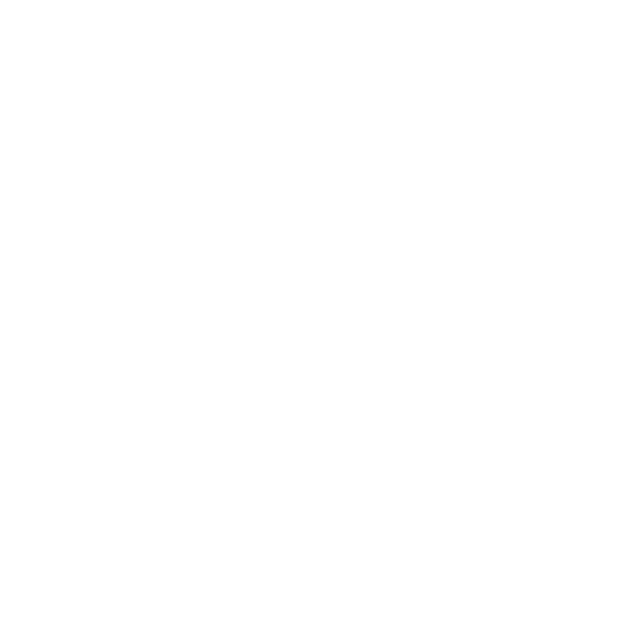

In [13]:
%matplotlib notebook
volume_BigGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### b) Small gap detection panels

<IPython.core.display.Javascript object>


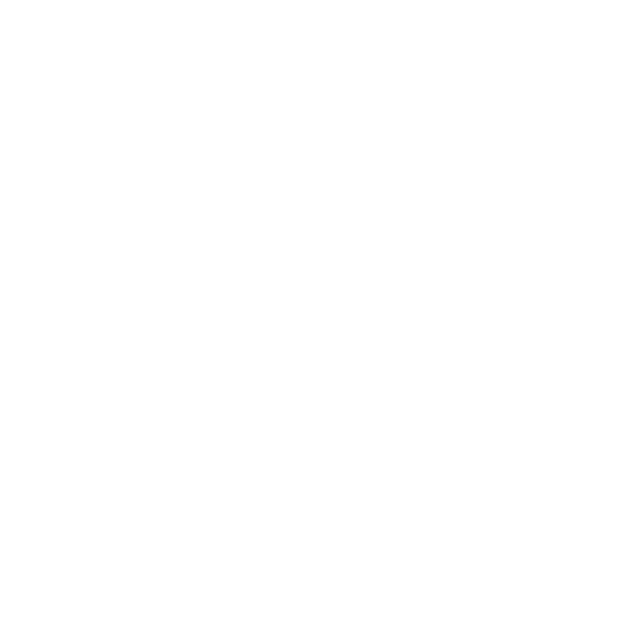

In [14]:
%matplotlib notebook
volume_SmallGap.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

#### c) Not centred detection panels

<IPython.core.display.Javascript object>


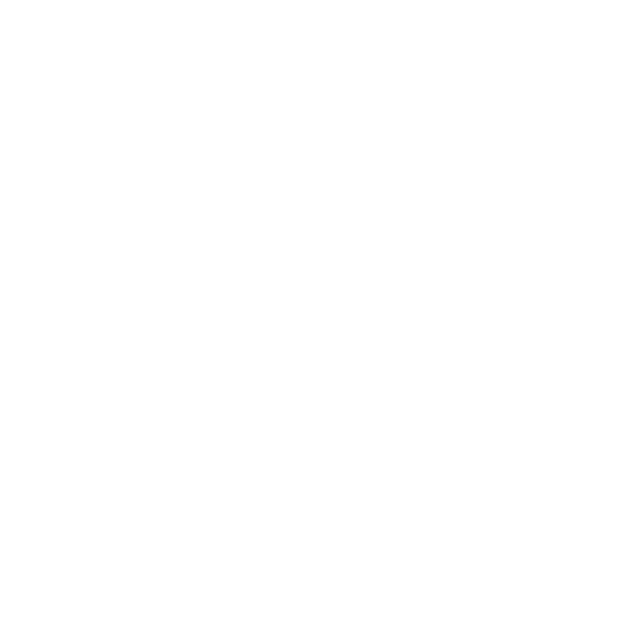

In [15]:
%matplotlib notebook
volume_NotCentred.draw(xlim=(-0.5,1.5), ylim=(-0.5,1.5), zlim=(-0.5,1.5))

In [16]:
%matplotlib inline

## **Choose scenario and define number of simulations and muon flux**

We'll continue defining the **number of simulations** we want to produce, their individual **data taking time**, and the considered **flux of muons**.

In [17]:
Simulations = 80 # number of simulations
Time = 0.1 # muography measurement time of a single simulation [min]
Flux = 6845 # considered flux of muons [muons/(min*m^2)]

# Choose scenario
Scenario = "BigGapHighRes"
Scenario = "BigGap"
Scenario = "SmallGap"
Scenario = "NotCentred"

## **Generate passive volumes**

Now we'll need to define how to **generate** example **passive volumes**. The furnace ladle is made of several elements:

 - **Ladle**: a $1\times1\times1 \:[\text{m}^3]$ bucket made of solid steel.

 - **Liquid steel**: The ladle is filled with a **random amount** of liquid steel.

 - **Slag**: Above the liquid steel is a **layer** of **slag**, with a lower density that liquid steel.

 - **Air**: The rest of the ladle is filled with air.


`LadleFurnacePassiveGenerator` class will create layouts based on varying fill-heights of a furnace ladle, with varying levels of slag.

In [18]:
from tomopt.benchmarks.ladle_furnace import LadleFurnacePassiveGenerator

In [19]:
if Scenario=="BigGapHighRes":
    volume=volume_BigGapHighRes
if Scenario=="BigGap":
    volume=volume_BigGap
if Scenario=="SmallGap":
    volume=volume_SmallGap
if Scenario=="NotCentred":
    volume=volume_NotCentred


print(volume)
# volume.get_detectors(), volume.get_passives()

passive_gen = LadleFurnacePassiveGenerator(volume)

Volume(
  (layers): ModuleList(
    (0): PanelDetectorLayer(
      (panels): ModuleList(
        (0): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.6000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (1): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5500]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
        (2): <class 'tomopt.volume.panel.SigmoidDetectorPanel'> located at xy=tensor([0.5000, 0.5000]), z=tensor([1.5000]), and xy span tensor([1., 1.]) with budget scale 1.4285714626312256
      )
    )
    (1): PassiveLayer located at z=tensor([1.4000])
    (2): PassiveLayer located at z=tensor([1.3000])
    (3): PassiveLayer located at z=tensor([1.2000])
    (4): PassiveLayer located at z=tensor([1.1000])
    (5): PassiveLayer located at z=tensor([1.])
    (6): PassiveLayer located at z=tensor([0.9000])
    (7): PassiveLay

We'll generate 10 volumes at a every fill-height. The 10cm of slag will be present for ever volume.

In [20]:
HEIGHTS = [0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
N_PASSIVES_PER_H = int(Simulations/len(HEIGHTS))

from tomopt.optimisation import PassiveYielder

trn_passives = PassiveYielder([passive_gen._generate(fixed_mat_z=h, fixed_slag_z=h+0.1)
                               for _ in range(N_PASSIVES_PER_H) for h in HEIGHTS])

This is the amount of passive volumes generated.

In [21]:
len(HEIGHTS), N_PASSIVES_PER_H, len(trn_passives)

(8, 10, 80)

Let's visualise one of these volume layouts by repurposing one of the visualisers in TomOpt

In [22]:
SelectedVolume = 10
f,t = trn_passives.passives[SelectedVolume]
volume.load_rad_length(f, t)

In [23]:
# Get X0 of all voxels
x0 = volume.get_rad_cube()
x0.shape, x0

(torch.Size([10, 10, 10]),
 tensor([[[1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02],
          [1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02, 1.7820e-02,
           1.7820e-02, 1.7820e-02, 1.7820e-0

In [24]:
from tomopt.plotting import plot_pred_true_x0
from tomopt.utils import x0targs_to_classtargs
from tomopt.core import X0

In [25]:
import numpy as np

In [26]:
type(1/np.sqrt(volume.get_rad_cube()))

torch.Tensor

In [27]:
volume.get_rad_cube()[:,4,4]*100

tensor([1.7820e+00, 1.9910e+00, 1.9910e+00, 1.9910e+00, 8.2110e+00, 3.0390e+04,
        3.0390e+04, 3.0390e+04, 3.0390e+04, 3.0390e+04])

true


<IPython.core.display.Javascript object>


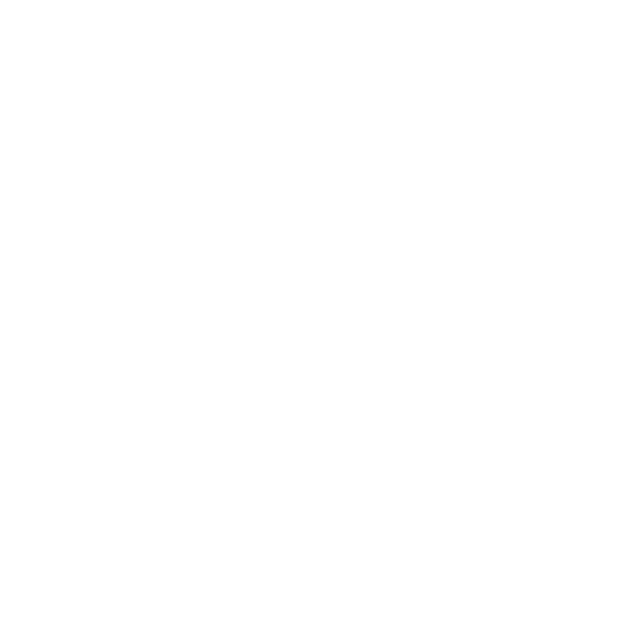

<IPython.core.display.Javascript object>


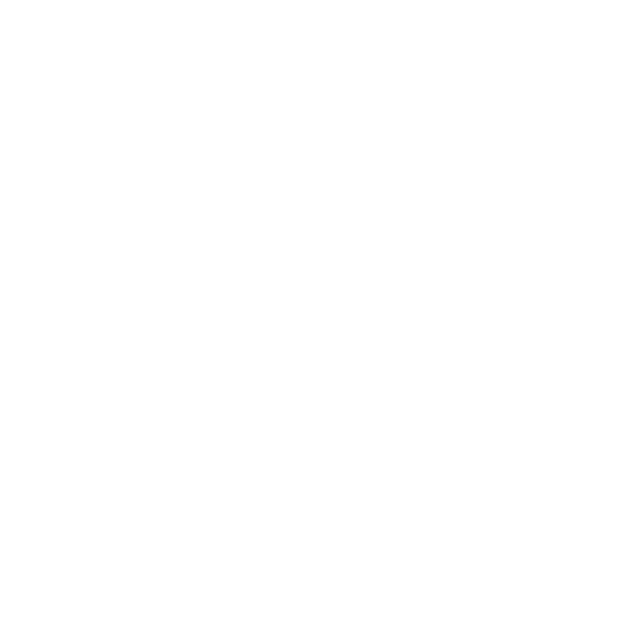

<IPython.core.display.Javascript object>


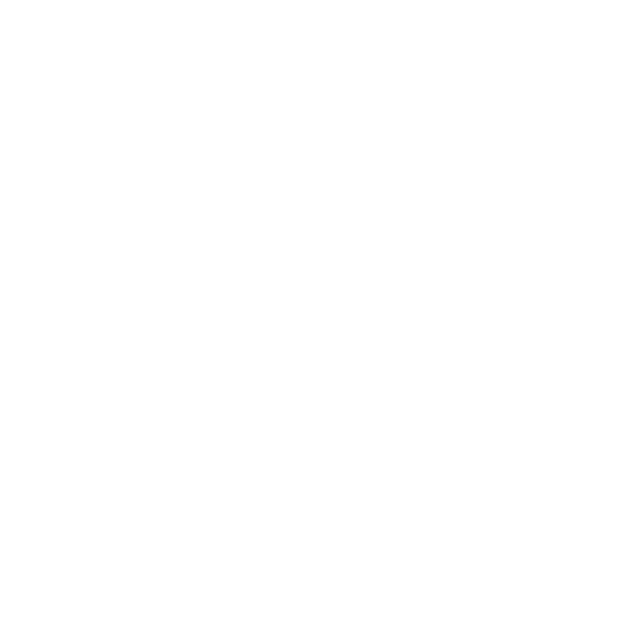

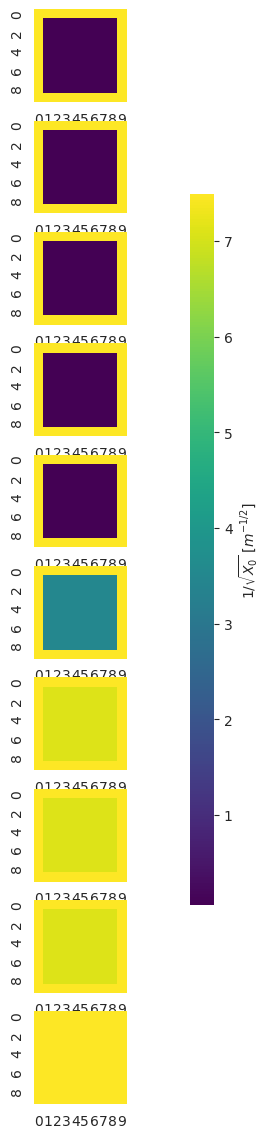

In [28]:
%matplotlib inline
# plot_pred_true_x0(pred=1/np.sqrt(volume.get_rad_cube()), true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X0} \ [cm^{-1/2}]$')
plot_pred_true_x0(true=1/np.sqrt(volume.get_rad_cube()), ColorBarLabel=r'$1/\sqrt{X_0} \ [m^{-1/2}]$')


In the plot of the cell above the layers of the ladle can be observed, coloured depending on the X0 of the voxel material:

 - Yellow = **ladle** (steel) 
 - Light green = **liquid steel** 
 - Dark green = **Slag** 
 - Blue = **Air**

The inverse of the square root of X0 has been plotted, a value which is approximately linear to the material density. We can see that the metals have very similar X0, but they are slightly distinguishable from the slag.

## **Muon generation and propagation**


In [29]:
from tomopt.muon import MuonGenerator2016 as MuonGenerator

In [30]:
# gen = MuonGenerator.from_volume(volume, fixed_mom=5)
gen = MuonGenerator.from_volume(volume, fixed_mom=None)
gen

Muon generator: x,y range: (-0.40192377427276926, 1.4019237742727693), (-0.40192377427276926, 1.4019237742727693). Energy sampled from 0.5087855416698359-491.5127197474533 GeV.

In [31]:
from tomopt.muon import MuonBatch

In [32]:
muons = MuonBatch(gen(2000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(0.6062), muons.y[0]=tensor(-0.3446), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.7605)'

In [33]:
volume(mu=muons)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(-0.1532), muons.y[0]=tensor(-1.8797), muons.z[0]=tensor(0.), muons.theta[0]=tensor(0.7605)'

In [34]:
hits = muons.get_hits()
hits

{'above': {'reco_xyz': tensor([[[ 5.2149e-01, -5.1599e-01,  1.6000e+00],
           [ 5.0038e-01,  9.4133e+01,  1.5500e+00],
           [ 4.7906e-01, -6.0008e-01,  1.5000e+00]],
  
          [[ 1.0924e+00,  3.6905e-02,  1.6000e+00],
           [ 1.1773e+00,  7.1637e-02,  1.5500e+00],
           [ 1.2454e+00,  1.0809e-01,  1.5000e+00]],
  
          [[ 1.2392e+00,  1.1106e+00,  1.6000e+00],
           [ 1.2459e+00,  1.1297e+00,  1.5500e+00],
           [ 1.2689e+00,  1.1354e+00,  1.5000e+00]],
  
          ...,
  
          [[ 1.3210e+00,  8.4201e-01,  1.6000e+00],
           [ 1.5461e+00,  8.1391e-01,  1.5500e+00],
           [ 1.3326e+00,  7.8702e-01,  1.5000e+00]],
  
          [[ 1.0457e+00,  1.2438e+00,  1.6000e+00],
           [ 1.0141e+00,  1.0708e+00,  1.5500e+00],
           [ 9.8359e-01,  1.2356e+00,  1.5000e+00]],
  
          [[ 8.0806e-01,  1.2461e+00,  1.6000e+00],
           [ 8.2252e-01,  1.1816e+00,  1.5500e+00],
           [ 8.3648e-01,  1.3976e+00,  1.5000e+00]]], gra

In [36]:
hits['above']['reco_xyz'].shape  # [muons, detector layer, xyz]

torch.Size([2000, 3, 3])

In [38]:
hits['above']['reco_xyz'][:, 0, 0] # [all muons, top layer, x]
hits['above']['reco_xyz'][:, 0, 1] # [all muons, top layer, y]

tensor([-0.5160,  0.0369,  1.1106,  ...,  0.8420,  1.2438,  1.2461],
       grad_fn=<SelectBackward0>)

In [40]:
import matplotlib.pyplot as plt

(array([ 13., 160., 284., 293., 302., 271., 250., 297., 125.,   5.]),
 array([-0.76167828, -0.5015583 , -0.24143831,  0.01868166,  0.27880165,
         0.53892159,  0.79904163,  1.05916154,  1.31928158,  1.57940149,
         1.83952153]),
 <BarContainer object of 10 artists>)

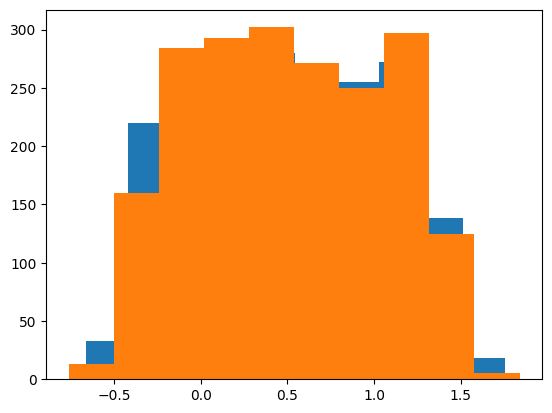

In [44]:
plt.hist(hits['above']['reco_xyz'][:, 0, 0].detach().numpy())
plt.hist(hits['above']['reco_xyz'][:, 0, 1].detach().numpy())

In [45]:
from tomopt.inference import ScatterBatch

In [46]:
%%time
sb = ScatterBatch(mu=muons, volume=volume)

CPU times: user 12.6 ms, sys: 2.89 ms, total: 15.5 ms
Wall time: 8.46 ms


# To do: control hits within span or not (or use efficiencies)

(array([540., 345., 262., 236., 186., 144., 121.,  78.,  67.,  21.]),
 array([1.64916200e-05, 9.84879956e-02, 1.96959510e-01, 2.95431018e-01,
        3.93902510e-01, 4.92374033e-01, 5.90845525e-01, 6.89317048e-01,
        7.87788570e-01, 8.86260033e-01, 9.84731555e-01]),
 <BarContainer object of 10 artists>)

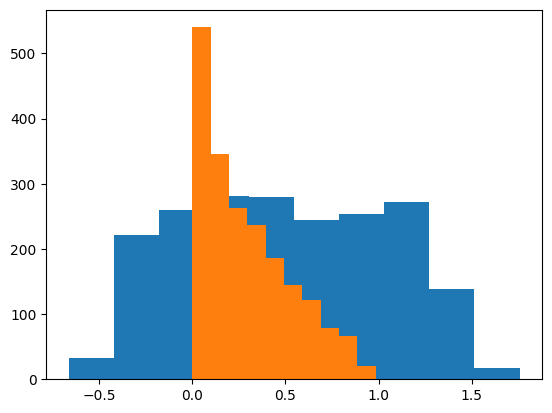

In [55]:
sb.above_gen_hits.shape
plt.hist(sb.above_gen_hits[:, 0, 0].detach().numpy())
plt.hist(sb.[:, 0, 0].detach().numpy())


In [47]:
%%time
sb.poca_xyz, sb.poca_xyz_unc

CPU times: user 39.7 s, sys: 27.1 s, total: 1min 6s
Wall time: 36.2 s


(tensor([[-0.0539, -1.6619,  0.2365],
         [ 2.9977,  0.9340,  0.3649],
         [ 1.4857,  1.3087,  0.7893],
         ...,
         [ 1.2437,  1.2323,  2.2873],
         [ 1.4367,  1.2952,  2.2311],
         [ 1.2407,  3.5489,  0.0784]], grad_fn=<AddBackward0>),
 tensor([[0.1510, 0.3554, 0.3584],
         [0.7660, 0.3708, 0.5101],
         [0.1511, 0.1142, 0.5252],
         ...,
         [0.1247, 0.5436, 0.9763],
         [0.7111, 0.1083, 1.1497],
         [0.4873, 2.4946, 1.6255]], grad_fn=<SqrtBackward0>))

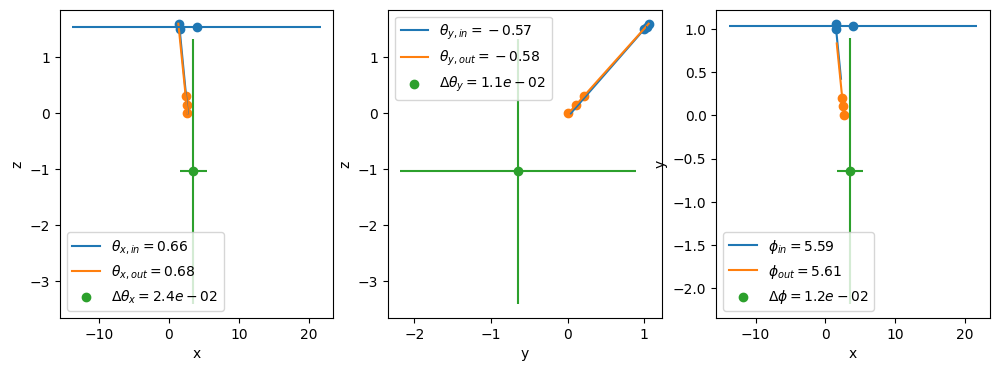

In [63]:
sb.plot_scatter(idx=0)

## **Inference example**
####  Assuming that POCA distribution centre in Z indicates the centre of steel volume

In [65]:
1/np.sqrt(volume.get_rad_cube()[:,4,4])

tensor([7.4911, 7.0870, 7.0870, 7.0870, 3.4898, 0.0574, 0.0574, 0.0574, 0.0574,
        0.0574])

0.30000000000000004

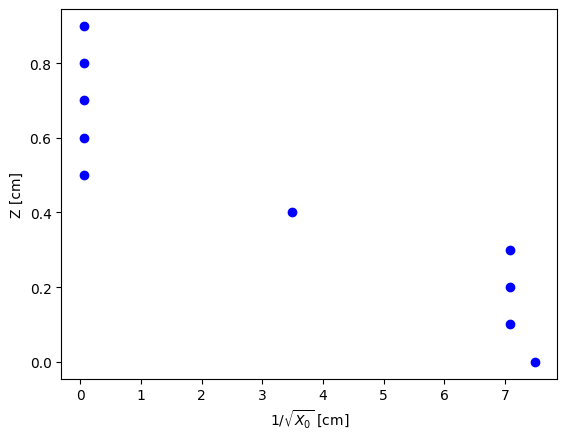

In [66]:
# Get true steel level
plt.plot(1/np.sqrt(volume.get_rad_cube()[:,4,4]), np.arange(0, len(np.sqrt(volume.get_rad_cube()[:,4,4])))*0.1, "bo")
plt.xlabel(r"$1/\sqrt{X_0}$ [cm]")
plt.ylabel("Z [cm]")

PassiveLayerThickness = 0.1
SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
SteelLevel_True

In [67]:
PocaZ = sb.poca_xyz[:, 2].detach().numpy()
FurnaceBottom = 0.5
SteelLevel_Pred = (np.mean(PocaZ)-FurnaceBottom)*2
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.9041


In [68]:
sb.poca_xyz.detach().cpu().numpy()[:, 0].shape

(2000,)

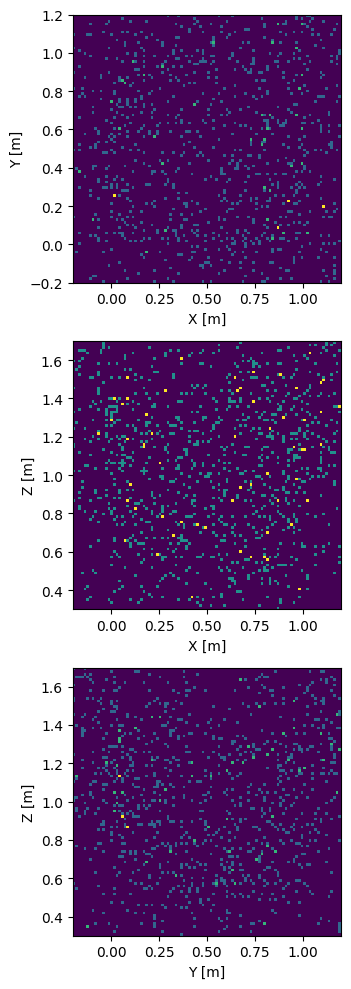

In [69]:
sb.plot_poca_batch(Zlims=[0.5-0.2, 1.5+0.2])

In [70]:
PocaZ

array([-1.0345665 ,  1.2210515 ,  1.4467947 , ...,  0.74650854,
        1.0132421 ,  0.68416053], dtype=float32)

#### All POCA

Actual steel level [m]: 0.3
Predicted steel level [m]: 0.8041


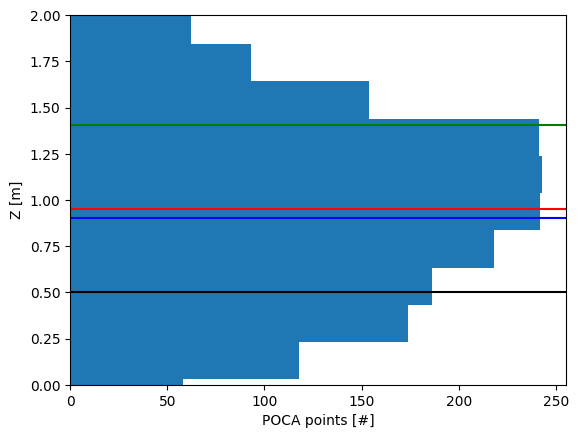

In [71]:
%matplotlib inline

FurnaceBottom = 0.5
BottomWallThickness = 0.1

PocaZ = sb.poca_xyz[:, 2].detach().numpy()

SteelLevel_Pred = (np.mean(PocaZ)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(PocaZ), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(PocaZ, bins=200, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()


#### POCA within furnace XY walls

In [72]:
Poca_x = sb.poca_xyz[:, 0].detach().numpy()
Poca_y = sb.poca_xyz[:, 1].detach().numpy()

f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
f_y = (Poca_y > 0.1) & (Poca_y < 0.9)


Actual steel level [m]: 0.3
Predicted steel level [m]: 0.7358


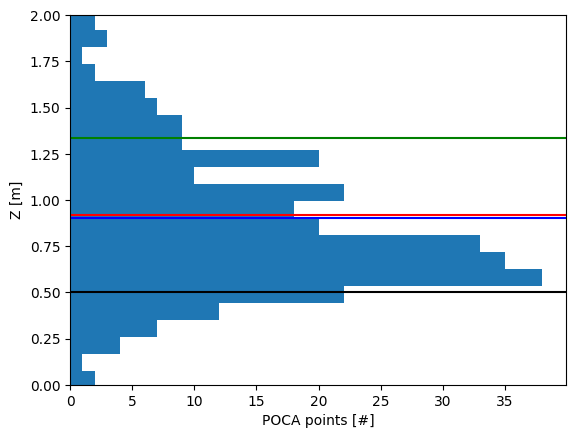

In [73]:
%matplotlib inline

Poca_z = sb.poca_xyz[:, 2].detach().numpy()
Poca_x = sb.poca_xyz[:, 0].detach().numpy()
Poca_y = sb.poca_xyz[:, 1].detach().numpy()

# Select POCA points within XY furnace walls
f_x = (Poca_x > 0.1) & (Poca_x < 0.9)
f_y = (Poca_y > 0.1) & (Poca_y < 0.9)
f = f_x & f_y

Poca_z = Poca_z[f]

SteelLevel_Pred = (np.mean(Poca_z)-(FurnaceBottom))*2-BottomWallThickness
print("Actual steel level [m]: " + str(round(SteelLevel_True, 4)))
print("Predicted steel level [m]: " + str(round(SteelLevel_Pred, 4)))
# np.mean(PocaZ)

plt.axhline(y=np.mean(Poca_z), color='r', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_Pred, color='g', linestyle='-')
plt.axhline(y=FurnaceBottom + BottomWallThickness + SteelLevel_True, color='b', linestyle='-')
plt.axhline(y=FurnaceBottom, color='k', linestyle='-')
# plt.axhline(y=FurnaceBottom+0.1, color='k', linestyle='-')

plt.hist(Poca_z, bins=50, orientation="horizontal")
plt.ylim(0,2)

plt.xlabel("POCA points [#]")
plt.ylabel("Z [m]")

plt.show()

# Run multiple simulations and get POCA mean and true steel level

### Generation

In [74]:
GeneratedMuons = 10000
muons = MuonBatch(gen(10000), init_z=1.8)
f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

'muons.x[0]=tensor(-0.3507), muons.y[0]=tensor(-0.1108), muons.z[0]=tensor(1.8000), muons.theta[0]=tensor(0.1863)'

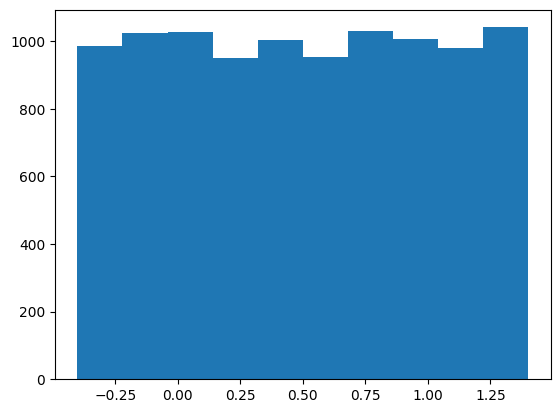

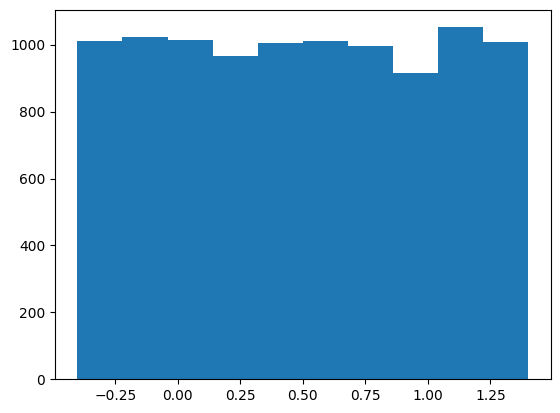

2.25

In [75]:
plt.hist(muons.x)
plt.show()

plt.hist(muons.y)
plt.show()

min(muons.x)

# Generation surface of 1.5x1.5 m²

1.5*1.5

In [78]:
from tomopt.tools import prog_bar

TrueSteelLevels = np.zeros(len(trn_passives.passives))
TrueSteelLevels[:] = np.nan

Poca_z_means = np.zeros(len(trn_passives.passives))
Poca_z_means[:] = np.nan

for i in range(0, len(trn_passives.passives)):
    # print(i)
    
    prog_bar(percent=100.0*(i+1)/len(trn_passives.passives))
    
    SelectedVolume = i
    f,t = trn_passives.passives[SelectedVolume]
    volume.load_rad_length(f, t)
    
    # plot_pred_true_x0(1/np.sqrt(volume.get_rad_cube()), 1/np.sqrt(volume.get_rad_cube()))
    
    GeneratedMuons = 1000
    muons = MuonBatch(gen(GeneratedMuons), init_z=1.8)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    volume(mu=muons)
    f'{muons.x[0]=}, {muons.y[0]=}, {muons.z[0]=}, {muons.theta[0]=}'

    sb = ScatterBatch(mu=muons, volume=volume)
    sb.poca_xyz, sb.poca_xyz_unc

    Poca_z = sb.poca_xyz[:, 2].detach().numpy()

    # within XY furnace walls
    Poca_x = sb.poca_xyz[:, 0].detach().numpy()
    Poca_y = sb.poca_xyz[:, 1].detach().numpy()

    # Select POCA points within XY furnace walls
    f_x = (Poca_x > 0.1+0.1) & (Poca_x < 0.9-0.1)
    f_y = (Poca_y > 0.1+0.1) & (Poca_y < 0.9-0.1)
    f_z = (Poca_y > 0.5) & (Poca_y < 1.5)
    f = f_x & f_y
    
    Poca_z = Poca_z[f]
    
    Poca_z_mean = np.mean(Poca_z)


    PassiveLayerThickness = 0.1
    SteelLevel_True = np.unique(volume.get_rad_cube()[:,4,4]==volume.get_rad_cube()[1,4,4], return_counts=True)[1][1]*PassiveLayerThickness
    SteelLevel_True

    
    TrueSteelLevels[i] = SteelLevel_True
    Poca_z_means[i] = Poca_z_mean
    


Completed: [==                                                                                        ]   2%

KeyboardInterrupt: 

In [45]:
np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_TrueSteelLevels.csv", TrueSteelLevels)
np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_PocaZmeans.csv", Poca_z_means)

# np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_WithPOCAoutOfLadleInterior_TrueSteelLevels.csv", TrueSteelLevels)
# np.savetxt("ladle_furnace_InferenceMethods/GeneratedData/" + Scenario + "_WithPOCAoutOfLadleInterior_PocaZmeans.csv", Poca_z_means)


In [46]:
Scenario

'NotCentred'

Text(0, 0.5, '$\\overline{Zpoca}$ [m]')

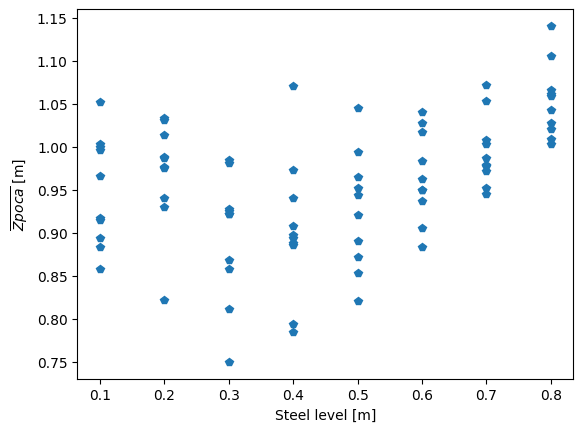

In [47]:
plt.plot(TrueSteelLevels, Poca_z_means, "p")
plt.xlabel("Steel level [m]")
plt.ylabel("$\overline{Zpoca}$ [m]")